$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Wind Speed Prediction Linear Regression Model

*Melinda Ryan and David Thorpe*

In [2]:
import numpy as np
#import mpl_toolkits.basemap as bm
import matplotlib
import matplotlib.pyplot as plt
import time
import datetime as dt
%matplotlib inline

In [3]:
def train(X,T):
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0)
    Xs = standardize(X-means,stds)#(X - means) / stds
    Xs1 = np.hstack((np.ones((Xs.shape[0],1)), Xs))                
    w = np.linalg.lstsq( np.dot(Xs1.T,Xs1), np.dot(Xs1.T, T) )[0]
    return {'means': means, 'stds': stds, 'w': w}
    

In [4]:
def standardize(a,b):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.divide( a, b )
        c[ ~ np.isfinite( c )] = 0  # -inf inf NaN
    return c

In [5]:
def use(X,model):
    #Standardize data
    Xs = standardize(X-model['means'],model['stds'])#(X - model['means']) / model['stds']
    #bias 
    Xs1 = np.hstack((np.ones((Xs.shape[0],1)), Xs)) 
    prediction = np.dot(Xs1,model['w'])
    return prediction

In [6]:
def rmse(predict,T):
    return np.sqrt(np.mean((predict - T)**2,axis=0))

In [7]:
def trainUsePlot(X,T):
    model = train(X,T)
    prediction = use(X,model)
    error = rmse(prediction,T)
    
    plt.plot(prediction,T,'o')
    plt.xlabel('Predicted WindSpeed')
    plt.ylabel('Actual WindSpeed')
    # add a 45 degree line
    a = max(min(prediction),min(T))
    b = min(max(prediction),max(T))
    plt.plot([a,b],[a,b], 'r', linewidth=3,alpha=0.5);
    
    print("RMSE: ", error)

In [36]:
def findBestPower(X,T,nFolds,maxPowers):
    results = []
    for Xtrain,Ttrain,Xtest,Ttest,_ in partitionKFolds(X,T,nFolds):
        for power in maxPowers:
            Xtrain2 = makeFeatures(Xtrain,power)
            Xtest2 = makeFeatures(Xtest,power)
            model = train(Xtrain2,Ttrain)
            trainError = rmse(use(Xtrain2,model),Ttrain),
            testError = rmse(use(Xtest2,model),Ttest)
            results.append([power,rmse(use(Xtrain2,model),Ttrain),rmse(use(Xtest2,model),Ttest)])
    results = np.array(results)
    realResults = meansAfterGroupedByFirstColumn(results)
    index = np.argmin(realResults[:,2])
    maxPow = realResults[index,0]
    return int(maxPow), realResults

In [37]:
# Code provided in CS480 lecture
def partitionKFolds(X,T,nFolds,shuffle=False,nPartitions=2):
    '''Usage: for Xtrain,Ttrain,Xval,Tval,Xtest,Ttext in partitionKFolds(X,T,5):'''
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    for testFold in range(nFolds):
        if nPartitions == 3:
            # Repeat with validateFold taking each single fold, except for the testFold
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Return partition matrices, then suspend until called again.
                yield Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest,testFold
        else:
            # trainFolds are all remaining folds, after selecting test and validate folds
            trainFolds = np.setdiff1d(range(nFolds), [testFold])
            # Construct Xtrain and Ttrain by collecting rows for all trainFolds
            rows = []
            for tf in trainFolds:
                a,b = startsStops[tf]                
                rows += rowIndices[a:b].tolist()
            Xtrain = X[rows,:]
            Ttrain = T[rows,:]
            # Construct Xtest and Ttest
            a,b = startsStops[testFold]
            rows = rowIndices[a:b]
            Xtest = X[rows,:]
            Ttest = T[rows,:]
            # Return partition matrices, then suspend until called again.
            yield Xtrain,Ttrain,Xtest,Ttest,testFold

In [38]:
def meansAfterGroupedByFirstColumn(data):
    result = []
    uniqs = np.unique(data[:,0])
    for x in uniqs:
        forx = data[data[:,0] == x, 1:]
        result.append([x] + np.mean(forx,0).tolist())
    return np.array(result)

In [39]:
def makeFeatures(X,maxPower):
    X1 = X
    for i in range(maxPower - 1):
        n = i+2
        X2 = X**n
        X1 = np.concatenate((X1,X2),axis=1)
    return X1

In [54]:
def nonlinearfeatures(X,T,powers,folds):
    maxPow,avgs = findBestPower(X,T,folds,powers)
    print('Max Power: ',maxPow)
    print('Matrix: \n',avgs)
    
    plt.plot(powers,avgs[:,1], label='Train Error')
    plt.plot(powers,avgs[:,2], label='Test Error')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Error')
    plt.xlabel('Power')
    plt.title('Training Error and Testing Error for Each Power')

In [16]:
names=['yearmoda','temp','dewp','slp','stp', 'visib','max','min','prcp','sndp','lat','lon','elev']

In [8]:
griddata = np.loadtxt('part-r-00000-1')

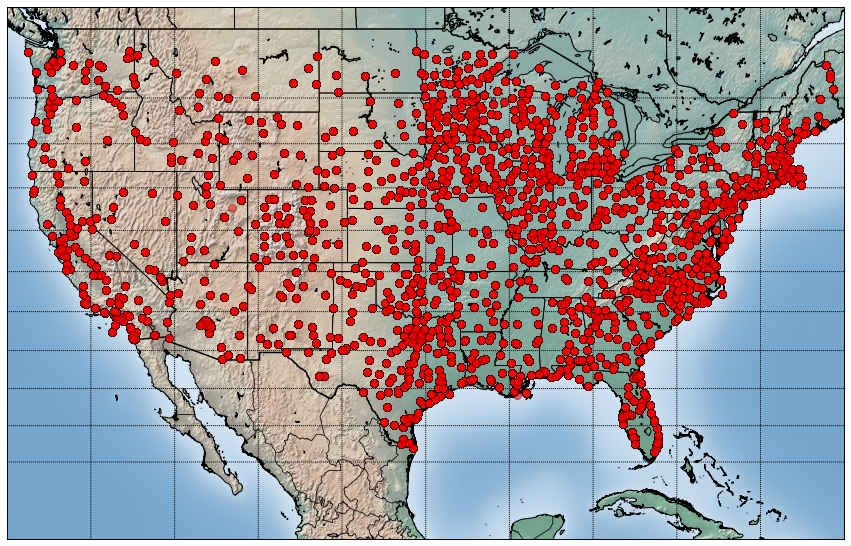

In [32]:
lats = griddata[:,15]/1000
lons = griddata[:,16]/1000
plt.figure(figsize=(15,30))
m = bm.Basemap(projection='merc', lat_0=36.5, lon_0=-96.5, 
              resolution = 'h', area_thresh = 0.1, llcrnrlon=-126.0, llcrnrlat=20.0, urcrnrlon=-67.0, urcrnrlat=50.0)
m.shadedrelief()
m.drawcoastlines()
m.drawcountries(linewidth=1.5, linestyle='solid', color='k')
m.drawstates(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
#m.fillcontinents(color='gray')
m.drawmapboundary()
m.drawmeridians(np.arange(-126,-67,5.9))
m.drawparallels(np.arange(25,48,2.3))

x,y = m(lons, lats)
m.plot(x,y, 'ro', markersize=8,alpha=0.1)
plt.show()

In [9]:
# Southern Rocky Mountain region is columns 2 and 3 in the grid
colSelection = np.logical_or(griddata[:,1]==2, griddata[:,1]==3)
rockies=griddata[colSelection,:]
# Southern Rocky Mountain region are rows 3,4,5,6 starting from the bottom up
rowSelection = np.logical_or(np.logical_or(rockies[:,0]==3, rockies[:,0]==4), 
                             np.logical_or(rockies[:,0]==5, rockies[:,0]==6))
rockies=rockies[rowSelection,:]

# Lats and lons in thousandths
lats = rockies[:,15]/1000
lons = rockies[:,16]/1000

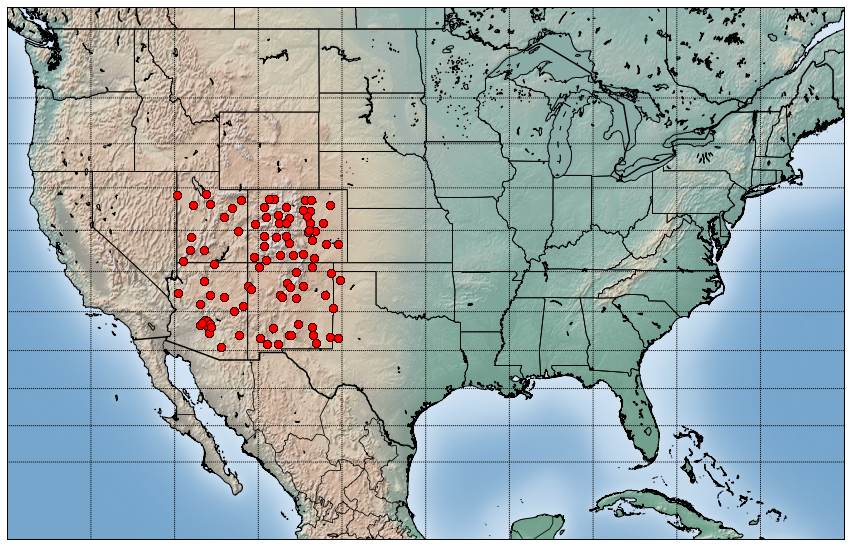

In [10]:
import mpl_toolkits.basemap as bm
plt.figure(figsize=(15,30))
m = bm.Basemap(projection='merc', lat_0=36.5, lon_0=-96.5, 
              resolution = 'h', area_thresh = 0.1, llcrnrlon=-126.0, llcrnrlat=20.0, urcrnrlon=-67.0, urcrnrlat=50.0)
m.shadedrelief()
m.drawcoastlines()
m.drawcountries(linewidth=1.5, linestyle='solid', color='k')
m.drawstates(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
m.drawmapboundary()
m.drawmeridians(np.arange(-126,-67,5.9))
m.drawparallels(np.arange(25,48,2.3))

x,y = m(lons, lats)
m.plot(x,y, 'ro', markersize=8)
plt.show()

In [10]:
# South Central region are columns 4 and 5 in the grid also the section 3,2 is in this region.
colSCentral = np.logical_or(np.logical_or(griddata[:,1]==4, np.logical_and(griddata[:,1]==5,griddata[:,0]!=7)),
                         np.logical_and(griddata[:,1]==3,griddata[:,0]==2))
SCentral=griddata[colSCentral,:]
# Rockies region are rows 3,4,5,6 starting from the bottom up
rowSCentral = np.logical_or(np.logical_or(np.logical_or(SCentral[:,0]==0,SCentral[:,0]==1), 
                                       np.logical_or(SCentral[:,0]==2,SCentral[:,0]==3)),
                         np.logical_or(np.logical_or(SCentral[:,0]==4,SCentral[:,0]==5),
                                       np.logical_or(SCentral[:,0]==6,SCentral[:,0]==7)))
SCentral=SCentral[rowSCentral,:]

# Lats and lons in thousandths
lats = SCentral[:,15]/1000
lons = SCentral[:,16]/1000

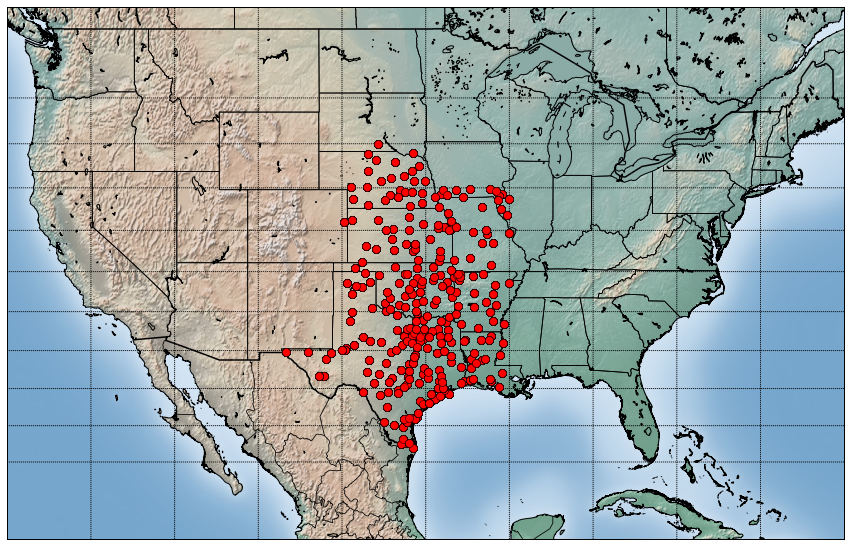

In [12]:
plt.figure(figsize=(15,30))
m = bm.Basemap(projection='merc', lat_0=36.5, lon_0=-96.5, 
              resolution = 'h', area_thresh = 0.1, llcrnrlon=-126.0, llcrnrlat=20.0, urcrnrlon=-67.0, urcrnrlat=50.0)
m.shadedrelief()
m.drawcoastlines()
m.drawcountries(linewidth=1.5, linestyle='solid', color='k')
m.drawstates(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
m.drawmapboundary()
m.drawmeridians(np.arange(-126,-67,5.9))
m.drawparallels(np.arange(25,48,2.3))

x,y = m(lons, lats)
m.plot(x,y, 'ro', markersize=8)
plt.show()

In [11]:
# North Central region are columns 4 and 5 in the grid.
colNCentral = np.logical_or(griddata[:,1]==4, griddata[:,1]==5,)
NCentral=griddata[colNCentral,:]
# Rockies region are rows 7,8,9 starting from the bottom up
rowNCentral = np.logical_or(np.logical_or(NCentral[:,0]==7,NCentral[:,0]==8), NCentral[:,0]==9)
NCentral=NCentral[rowNCentral,:]

# Lats and lons in thousandths
lats = NCentral[:,15]/1000
lons = NCentral[:,16]/1000

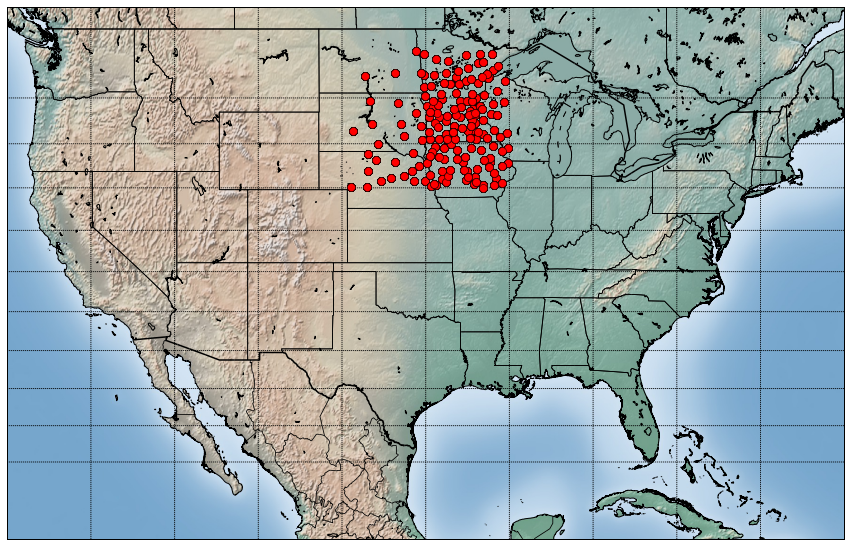

In [14]:
plt.figure(figsize=(15,30))
m = bm.Basemap(projection='merc', lat_0=36.5, lon_0=-96.5, 
              resolution = 'h', area_thresh = 0.1, llcrnrlon=-126.0, llcrnrlat=20.0, urcrnrlon=-67.0, urcrnrlat=50.0)
m.shadedrelief()
m.drawcoastlines()
m.drawcountries(linewidth=1.5, linestyle='solid', color='k')
m.drawstates(linewidth=0.8, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
m.drawmapboundary()
m.drawmeridians(np.arange(-126,-67,5.9))
m.drawparallels(np.arange(25,48,2.3))

x,y = m(lons, lats)
m.plot(x,y, 'ro', markersize=8)
plt.show()

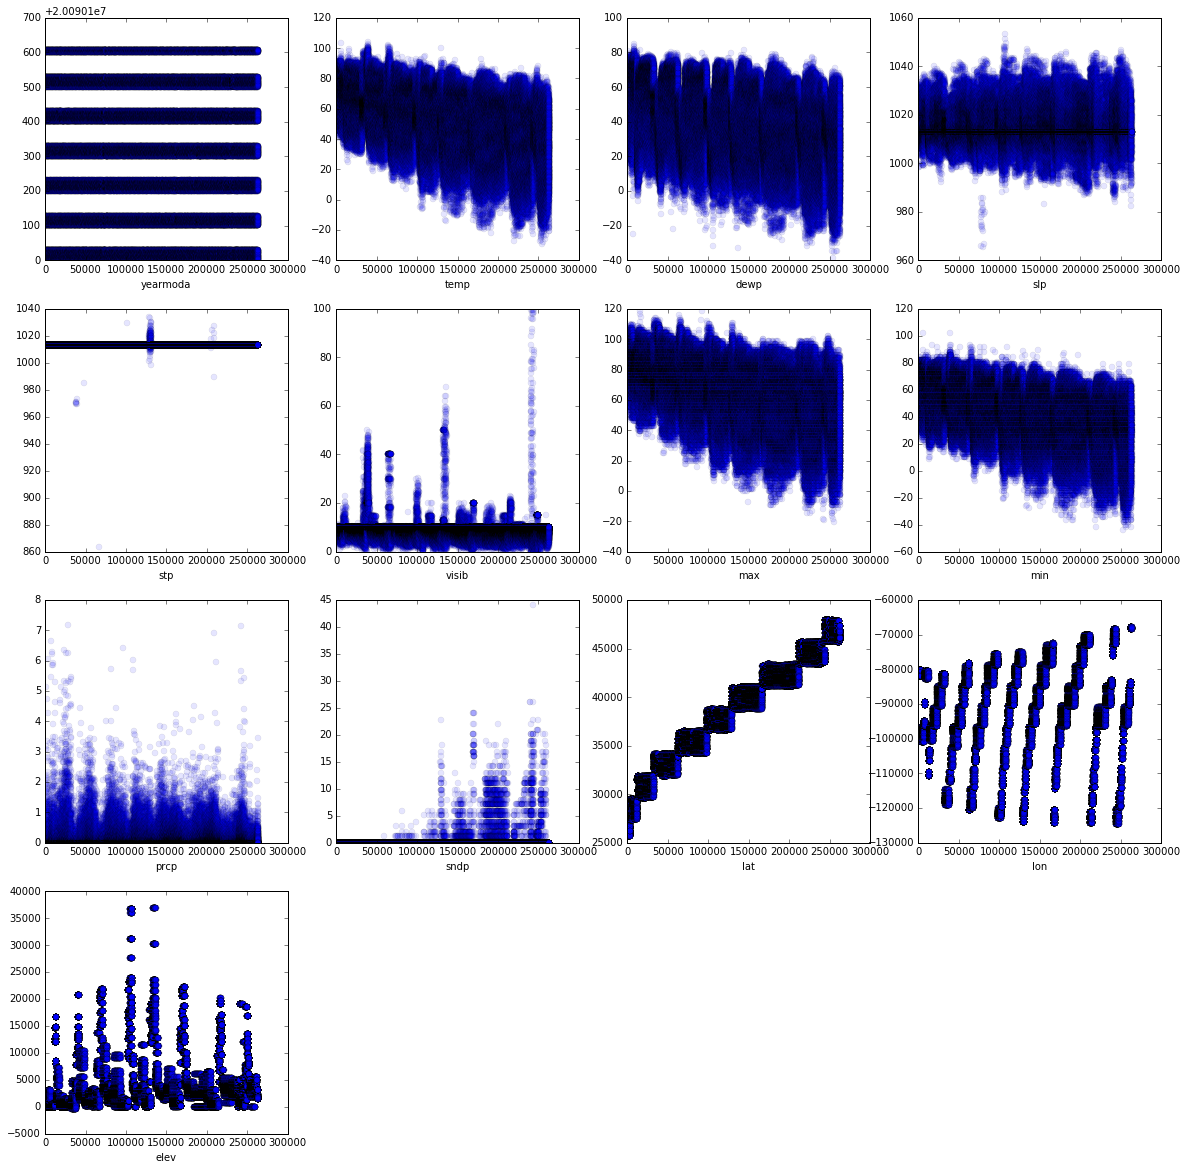

In [34]:
plt.figure(figsize=(20,20))
row,col = Xtest.shape
for i in range(col):
    plt.subplot(4,4, i+1)
    plt.plot(Xtest[:,i],'o',alpha=0.1)
    plt.xlabel(names[i])

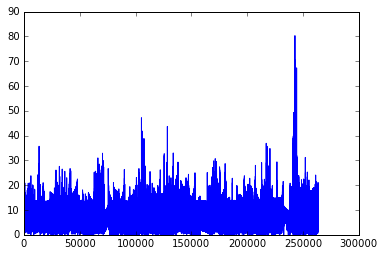

In [35]:
plt.plot(Ttest)

In [27]:
def convertToDate(val):
    val=val.astype(np.int64)
    date=np.array_str(val)
    date = time.strptime(date, "%Y%m%d") 
    date=dt.datetime(*date[:6])
    return date

In [28]:
dates = []
for i in griddata[:,5]:
    dates.append(convertToDate(i))
plotdates = matplotlib.dates.date2num(dates)

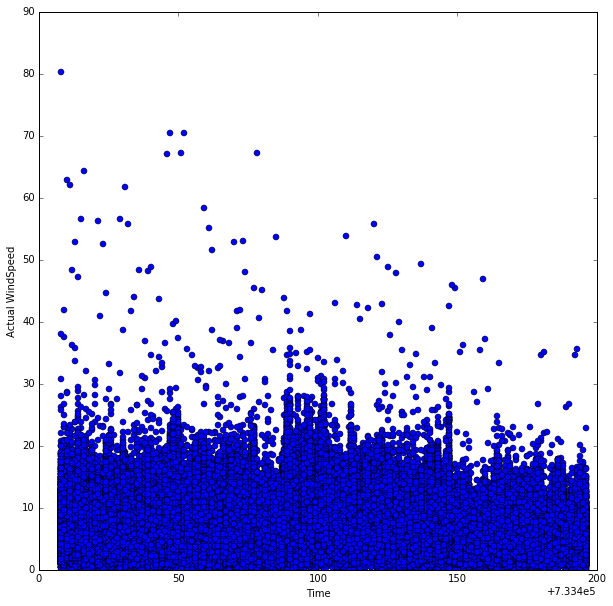

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10,10))
plt.plot(plotdates,Ttest,'o')
#plt.plot(20090630,1,'ro')
axes = plt.gca()

plt.xlabel('Time')
plt.ylabel('Actual WindSpeed')

In [12]:
Xtest = griddata[:,5:19]
Xtest.shape

(263548, 13)

In [15]:
Ttest=griddata[:,2:3]
Ttest.shape

(263548, 1)

In [18]:
testModel = train(Xtest,Ttest)
testPrediction = use(Xtest,testModel)

In [31]:
error = rmse(testPrediction,Ttest)
error

array([ 3.57683687])

In [33]:
w = testModel['w']
for wi,name in zip(w.flat,names):
    print('{:8.3f}  {:s}'.format(wi,name))

   6.811  yearmoda
  -0.654  temp
  -2.527  dewp
  -1.836  slp
  -0.695  stp
  -0.016  visib
   0.229  max
  -0.030  min
   4.436  prcp
   0.173  sndp
   0.227  lat
   0.133  lon
   0.006  elev


Max Power:  3
Matrix: 
 [[  1.           3.5695467    3.649292  ]
 [  2.           3.40155922   3.8450918 ]
 [  3.           3.34163447   3.48941159]
 [  4.           3.29612727  10.08790395]
 [  5.           3.29635996   7.34893541]]


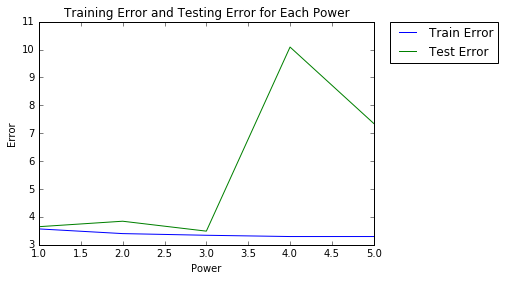

In [48]:
# nonlinearfeatures requires the feature matrix, target vector, range of powers to try, and the number of folds
powers = range(1,6)
nonlinearfeatures(Xtest,Ttest,powers,5)

In [19]:
rockiesX=rockies[:,5:19]
rockiesT=rockies[:,2:3]

In [20]:
scentralX=SCentral[:,5:19]
scentralT=SCentral[:,2:3]

In [21]:
ncentralX=NCentral[:,5:19]
ncentralT=NCentral[:,2:3]

RMSE:  [ 3.46752575]


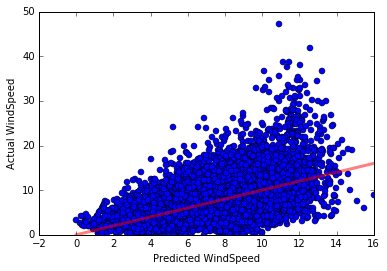

In [22]:
trainUsePlot(rockiesX,rockiesT)

RMSE:  [ 3.49942534]


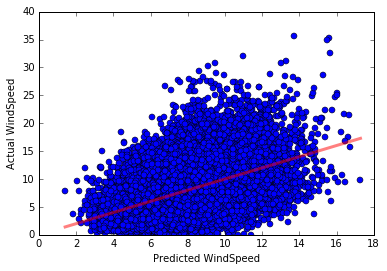

In [23]:
trainUsePlot(scentralX,scentralT)

RMSE:  [ 3.65569297]


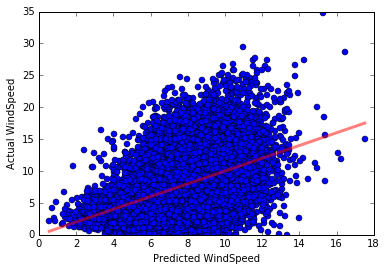

In [24]:
trainUsePlot(ncentralX,ncentralT)

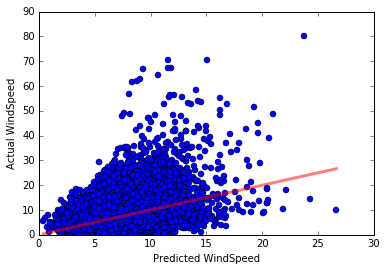

In [30]:
plt.plot(testPrediction,Ttest,'o')
plt.xlabel('Predicted WindSpeed')
plt.ylabel('Actual WindSpeed')
# add a 45 degree line
a = max(min(testPrediction),min(Ttest))
b = min(max(testPrediction),max(Ttest))
plt.plot([a,b],[a,b], 'r', linewidth=3,alpha=0.5);

Max Power:  2
Matrix: 
 [[ 1.          3.45168786  3.58396719]
 [ 2.          3.21289039  3.50929688]
 [ 3.          3.08143758  4.65309778]]


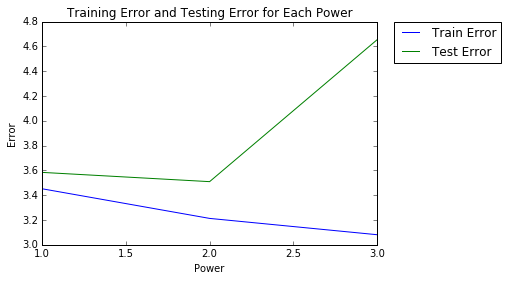

In [60]:
powers = range(1,4)
nonlinearfeatures(rockiesX,rockiesT,powers,5)

Max Power:  3
Matrix: 
 [[ 1.          3.48964348  3.58240673]
 [ 2.          3.29031852  3.60648838]
 [ 3.          3.22140256  3.53785593]]


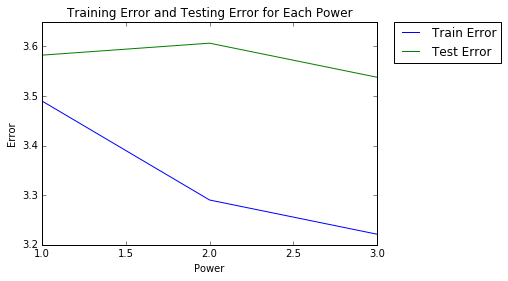

In [59]:
powers = range(1,4)
nonlinearfeatures(scentralX,scentralT,powers,5)

Max Power:  2
Matrix: 
 [[ 1.          3.64811497  3.74354332]
 [ 2.          3.50027678  3.62837482]
 [ 3.          3.46029603  3.83555555]
 [ 4.          3.43957276  4.94241606]
 [ 5.          3.4318091   6.96111405]]


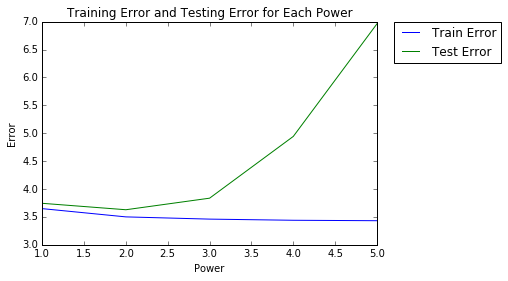

In [62]:
powers = range(1,6)
nonlinearfeatures(ncentralX,ncentralT,powers,5)